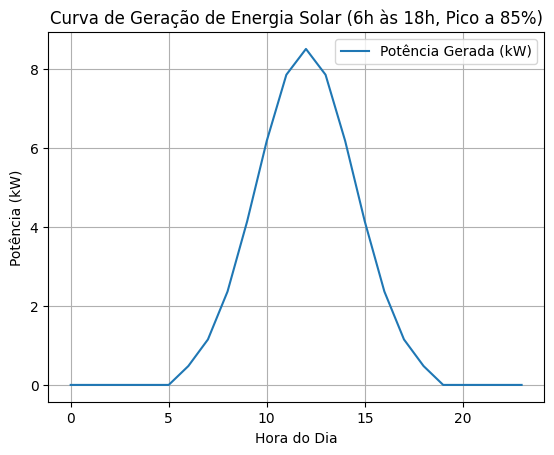

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

horas = np.arange(0, 24)

# Simulação da curva de geração solar com uma distribuição aproximadamente normal
media = 12
desvio_padrao = 2.5  # Ajuste fino para adequar a curva ao intervalo de 6h às 18h
curva_normal = np.exp(-0.5 * ((horas - media) / desvio_padrao) ** 2)

# Normalizando a curva para que o pico seja 85% da potência instalada
curva_normal = curva_normal / np.max(curva_normal) * 0.85

# Zerando a geração fora do intervalo de sol (6h às 18h)
curva_normal[horas < 6] = 0
curva_normal[horas > 18] = 0

# Potência de pico como exemplo, só pra plotar a curva
potencia_pico = 10 

# Calculando a potência gerada em cada hora do dia
potencia_gerada = potencia_pico * curva_normal

tabela_geracao = pd.DataFrame({
    'Hora': horas,
    'Percentual (%)': curva_normal * 100,
    'Potência Gerada (kW)': potencia_gerada
})


# Plotando a curva de geração de energia solar
plt.plot(horas, potencia_gerada, label="Potência Gerada (kW)")
plt.xlabel("Hora do Dia")
plt.ylabel("Potência (kW)")
plt.title("Curva de Geração de Energia Solar (6h às 18h, Pico a 85%)")
plt.grid(True)
plt.legend()
plt.show()

# Clientes entrantes de GD

In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

path = r'C:\Users\ruanv\OneDrive\Documentos\Mestrado\Projeto de Mestrado\bases'

entrantes = pd.read_csv(os.path.join(path,'entrantesGD.txt'), sep='\t', encoding='latin-1')
clientes = pd.read_csv(os.path.join(path,'clientesEPB.csv'), sep=';', encoding='latin-1')
# d3 = pd.concat([d1, d2])

entrantes = entrantes.dropna(subset=['data_inicio_injecao'])

entrantes = entrantes[['num_uc_geradora', 'nomelcd', 'tipos_fonte_geracao',  'pot_instalada_solar', 'data_inicio_injecao']]

entrantes.rename(columns={
    'num_uc_geradora': 'UC',
    'nomelcd': 'Localidade',
    'tipos_fonte_geracao': 'Fonte',
    'pot_instalada_solar': 'PotenciaInstalada',
    'data_inicio_injecao': 'DataInicioInjecao'
}, inplace=True)

entrantes['PotenciaInstalada'] = entrantes['PotenciaInstalada'].str.replace(',', '.')

entrantes = entrantes.astype({
    'UC': 'int',
    'Localidade': 'object',
    'Fonte': 'object',
    'PotenciaInstalada': 'float64',
    'DataInicioInjecao': 'object'
})


clientes = clientes[['UC', 'ALIMENTADOR', 'SUBESTACAO', 'DATA_ENCERRAMENTO_DO_CONTRATO',
       'LIVRO', 'NOME_LOCALIDADE', 'LAT_SIATE',
       'LONG_SIATE', 'LAT_SILCO', 'LONG_SILCO', ]]


clientes['UC'] = pd.to_numeric(clientes['UC'], errors='coerce')
clientes = clientes.dropna(subset=['UC'])
clientes = clientes.astype({
    'UC': 'int'
})

geradores = pd.merge(entrantes, clientes, on='UC',how='left')

def trocar_colunas(df):
    for index, row in df.iterrows():        
        alimentador = row['ALIMENTADOR']
        subestacao = row['SUBESTACAO']
        
        # Verifica se o alimentador tem o formato de subestação e vice-versa, pq contece bastante na base...
        if isinstance(alimentador, str) and isinstance(subestacao, str):
            if len(alimentador) == 3: #and alimentador.isupper() and 'L' in subestacao:
                # Troca os valores se estiverem trocados
                df.at[index, 'ALIMENTADOR'] = subestacao
                df.at[index, 'SUBESTACAO'] = alimentador

    return df

geradores['SUBESTACAO'] = geradores['SUBESTACAO'].str.replace(' ', '').str[:3]
geradores['ALIMENTADOR'] = geradores['ALIMENTADOR'].str.replace(' ', '').str[:3]

geradores = trocar_colunas(geradores)

geradores['CIRCUITO'] = geradores['SUBESTACAO']+'-'+geradores['ALIMENTADOR']

subestacoes = pd.read_excel(os.path.join(path,'subestacoes.xlsx'), usecols='A:G')
subestacoes['Equipamento Medição'] = subestacoes['SUBESTACAO']+'_DJ_'+subestacoes['DISJUNTOR']
subestacoes['TRAFO'] = subestacoes['SUBESTACAO']+"-"+subestacoes['TRAFO']
subestacoes = subestacoes[['TRAFO', 'Equipamento Medição', 'ALIMENTADOR', 'POTENCIA (MVA)']]

geradores_e_ses = pd.merge(geradores, subestacoes, left_on='CIRCUITO', right_on='ALIMENTADOR')
geradores_e_ses = geradores_e_ses.drop_duplicates()

geradores_e_ses['PotenciaInstalada_MW'] = geradores_e_ses['PotenciaInstalada']/1000

geradores_e_ses = geradores_e_ses[['Localidade', 'Fonte', 'DataInicioInjecao', 'CIRCUITO', 'TRAFO', 'Equipamento Medição', 'POTENCIA (MVA)', 'PotenciaInstalada_MW']]

df = geradores_e_ses

df['DataInicioInjecao'] = pd.to_datetime(df['DataInicioInjecao'], format='%d/%m/%Y %H:%M:%S')

# Função para calcular a potência acumulada para um TRAFO específico
def calcular_potencia_acumulada_por_trafo(grupo):
    # Criar DataFrame de eventos de adição (injeção de potência) para o grupo
    eventos_adicao = grupo[['DataInicioInjecao', 'PotenciaInstalada_MW']].rename(columns={'DataInicioInjecao': 'Tempo', 'PotenciaInstalada_MW': 'Potencia'})
    eventos_adicao['Tipo'] = 'adicao'

    # Criar DataFrame com as potências de hora em hora
    start_time = grupo['DataInicioInjecao'].min().floor('H')
    end_time = pd.Timestamp.now().floor('H')  # Define o tempo final para o cálculo
    time_range = pd.date_range(start=start_time, end=end_time, freq='H')
    potencia_instalada = pd.DataFrame({'Tempo': time_range})

    # Inicializar a potência acumulada
    potencia_instalada['PotenciaAcumulada'] = 0

    # Ordenar eventos por tempo
    eventos_adicao = eventos_adicao.sort_values(by='Tempo').reset_index(drop=True)

    # Calcular a potência acumulada
    potencia = 0
    event_index = 0
    num_events = len(eventos_adicao)

    for i in range(len(potencia_instalada)):
        current_time = potencia_instalada.loc[i, 'Tempo']

        # Atualiza a potência acumulada com base nos eventos de adição
        while event_index < num_events and eventos_adicao.loc[event_index, 'Tempo'] <= current_time:
            potencia += eventos_adicao.loc[event_index, 'Potencia']
            event_index += 1

        potencia_instalada.loc[i, 'PotenciaAcumulada'] = potencia

    return potencia_instalada

# Aplicar a função para cada TRAFO separadamente
resultados = []

for trafo, grupo in df.groupby('TRAFO'):
    potencia_acumulada_por_trafo = calcular_potencia_acumulada_por_trafo(grupo)
    potencia_acumulada_por_trafo['TRAFO'] = trafo  # Adicionar coluna TRAFO
    resultados.append(potencia_acumulada_por_trafo)

potencia_instalada_final = pd.concat(resultados).reset_index(drop=True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ruanv\\OneDrive\\Documentos\\Mestrado\\Projeto de Mestrado\\bases\\geradoresGD.txt'